# Random Forest + (MDI, Permutation, Boruta)
## Data
We have 5000 historical training data. Each client is described with 500 variables (variables are anonymized).
Your task is to build a model that predicts which customers in the test set took advantage of the offer.

### The training data:
- x_train.txt - variable matrix for training data for 5000 households
- y_train.txt — labels (value 1 = usage above threshold, value 0 = usage within acceptable range)

### Test data:
- x_test.txt - variable matrix containing information about 5000 households.

## Goal
Your goal is to build a model on the training data and then identify 1,000 households in the test set that you predict will exceed the energy usage threshold next month. Here the goal is to evaluate RandomForestClassifier alongside following feature selection methods:
 - Mean Deacrese in Impurity
 - Permutation based measure
 - Boruta algorithm

## Model evaluation 
Performance of your model will be scored as follows:
- For each correctly identified household (i.e., one that did indeed exceed the threshold), the utility company pays you EUR 10.
- For each variable used in your model, you must pay EUR 200 to simulate the cost of acquiring and processing that data.
### Example 1:
Your model correctly identifies 850 out of 1,000 households. You used 12 variables.
- Reward: 850 × 10 EUR = EUR 8500
-Variable cost: 12 × 200 EUR = EUR 2400
- Final score = EUR 8500 − EUR 2400 = EUR 6100

In [1]:
# Add parent directory to PYTHONPATH of the notebook
import os
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
print(f"Adding parent directory to sys.path: {parent_dir}")
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

%load_ext autoreload
%autoreload 2

Adding parent directory to sys.path: c:\Users\Łukasz\OneDrive - Politechnika Warszawska\MINI_1D\Semestr 8\Advanced ML\Project_2\AML_Feature_Selection


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.inspection import permutation_importance
import sklearn.metrics as skm
from sklearn.feature_selection import SelectFromModel
from src.utils import calculate_custom_score

# For Boruta algorithm
from boruta import BorutaPy

# Data visualization settings
# plt.style.use('seaborn-whitegrid')
# plt.rcParams['figure.figsize'] = (12, 8)

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Path to data files
data_path = '../data/'

# Exploration
## 1. Data Loading and Exploration

In [3]:
# Load the data
X_train = pd.read_csv(data_path + 'x_train.txt', delimiter=' ', header=None)
y_train = pd.read_csv(data_path + 'y_train.txt', delimiter=' ', header=None).squeeze()
X_test = pd.read_csv(data_path + 'x_test.txt', delimiter=' ', header=None)

# Rename columns for better readability
X_train.columns = [f'feature_{i}' for i in range(X_train.shape[1])]
X_test.columns = [f'feature_{i}' for i in range(X_test.shape[1])]

# Display basic information about the data
print("Training data shape:", X_train.shape)
print("Target variable shape:", y_train.shape)
print("Test data shape:", X_test.shape)
print("\nClass distribution in training data:")
print(y_train.value_counts(normalize=True) * 100)

# Split the training data into train and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train
)

print("\nAfter splitting:")
print("Train set shape:", X_train_split.shape)
print("Validation set shape:", X_val.shape)

display(X_train_split.head())
display(y_train_split)


Training data shape: (5000, 500)
Target variable shape: (5000,)
Test data shape: (5000, 500)

Class distribution in training data:
0
0    51.14
1    48.86
Name: proportion, dtype: float64

After splitting:
Train set shape: (4000, 500)
Validation set shape: (1000, 500)


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_490,feature_491,feature_492,feature_493,feature_494,feature_495,feature_496,feature_497,feature_498,feature_499
1796,10.994454,7.223997,18.905844,15.302758,11.335159,11.268610,16.742562,11.595944,11.898338,11.381933,...,8.083485,9.417854,18.105234,2.648145,6.880692,4.950240,11.992575,8.532587,14.966706,21.897683
3243,18.329623,13.311553,24.541799,16.356399,20.784595,11.251973,15.867162,17.039225,10.326017,16.232807,...,13.244366,8.005045,4.562646,5.814640,11.137799,19.105339,4.509459,10.775882,3.348956,7.777499
2491,8.856867,8.177936,16.285177,9.685481,11.551787,4.839914,10.932191,7.374404,8.853780,10.378997,...,9.533385,12.313883,3.841512,6.604631,7.065970,7.968559,13.224610,9.949868,2.687109,11.251411
2106,23.597065,22.040934,43.749375,30.131020,30.131190,16.708132,29.810484,25.257863,24.452841,27.266843,...,8.631784,7.659637,12.655417,5.507021,12.309867,2.966007,4.071214,17.345237,6.848255,11.848773
1644,20.971488,18.626463,33.579955,19.998639,26.105883,9.787864,20.467935,18.329333,14.347480,23.615695,...,12.014632,16.713876,6.763858,13.764160,6.576413,21.474574,6.643161,11.400546,11.648409,12.634681


1796    0
3243    0
2491    0
2106    1
1644    1
       ..
4365    0
611     0
1003    0
3743    0
818     1
Name: 0, Length: 4000, dtype: int64

## 2. Base Random Forest Model with Mean Decrease in Impurity (MDI)

In [4]:
# Train a Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=1000,
    max_depth=4,
    min_samples_split=4,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

n_features = X_train_split.shape[1]

# Fit the model
rf_model.fit(X_train_split, y_train_split)

# Evaluate on both training and validation sets
y_train_pred = rf_model.predict(X_train_split)
y_train_pred_proba = rf_model.predict_proba(X_train_split)[:, 1]
y_val_pred = rf_model.predict(X_val)
y_val_pred_proba = rf_model.predict_proba(X_val)[:, 1]

# Create DataFrame with metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'Expected Gain'],
    'Training': [
        accuracy_score(y_train_split, y_train_pred),
        precision_score(y_train_split, y_train_pred),
        recall_score(y_train_split, y_train_pred),
        f1_score(y_train_split, y_train_pred),
        roc_auc_score(y_train_split, y_train_pred_proba),
        calculate_custom_score(y_train_split, y_train_pred_proba, n_features)
    ],
    'Validation': [
        accuracy_score(y_val, y_val_pred),
        precision_score(y_val, y_val_pred),
        recall_score(y_val, y_val_pred),
        f1_score(y_val, y_val_pred),
        roc_auc_score(y_val, y_val_pred_proba),
        calculate_custom_score(y_val, y_val_pred_proba, n_features)
    ]
})

# Format the numbers to 4 decimal places
metrics_df['Training'] = metrics_df['Training'].map('{:.4f}'.format)
metrics_df['Validation'] = metrics_df['Validation'].map('{:.4f}'.format)

# Display the DataFrame
display(metrics_df)

# Get feature importances (MDI method)
mdi_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
})

# Sort features by importance (MDI)
mdi_importances = mdi_importances.sort_values('importance', ascending=False).reset_index(drop=True)
print("\nTop 20 features by MDI:")
print(mdi_importances.head(20))

,Metric,Training,Validation
0,Accuracy,0.7230,0.6950
1,Precision,0.7178,0.6933
2,Recall,0.7134,0.6748
3,F1 Score,0.7156,0.6839
4,ROC AUC,0.8126,0.7285
5,Expected Gain,-91830.0000,-95110.0000



Top 20 features by MDI:
        feature  importance
0     feature_2    0.107923
1     feature_6    0.078515
2     feature_3    0.066784
3     feature_7    0.062173
4     feature_8    0.061492
5     feature_4    0.059725
6     feature_5    0.054047
7     feature_0    0.047351
8     feature_1    0.045841
9   feature_414    0.032436
10    feature_9    0.030304
11  feature_462    0.030238
12  feature_425    0.024602
13  feature_356    0.002948
14  feature_451    0.001935
15  feature_332    0.001860
16  feature_121    0.001811
17  feature_293    0.001681
18  feature_339    0.001637
19   feature_86    0.001599


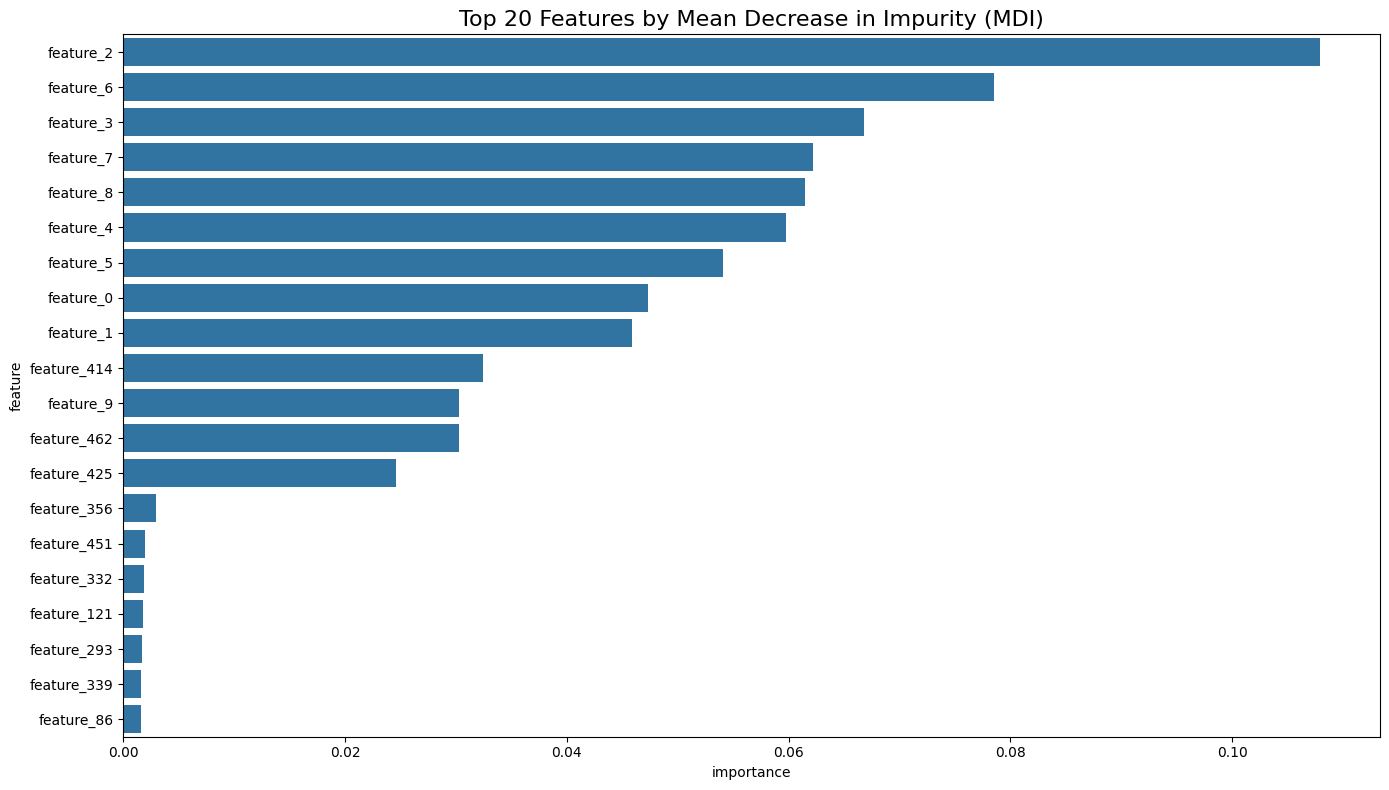

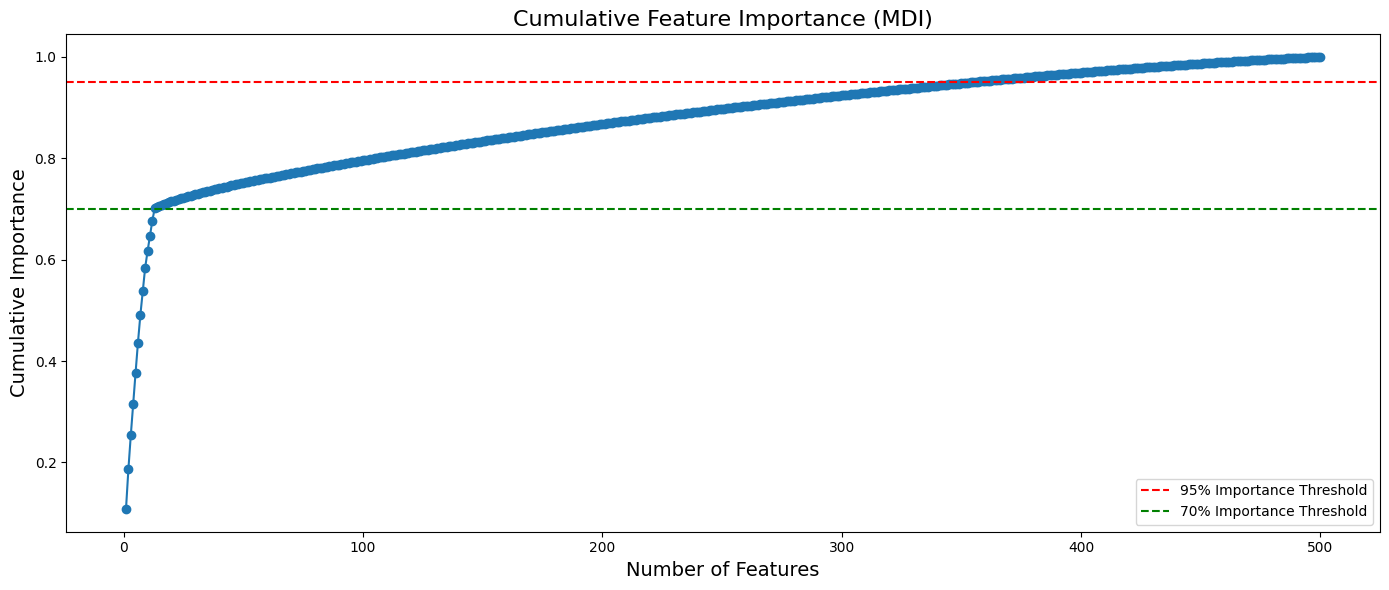

Number of features needed to reach 95% importance: 355
Number of features needed to reach 70% importance: 13
Number of features with importance > 0.01: 13
Cumulative importance of these features: 0.7014310246680582


In [5]:
# Visualize MDI feature importances
plt.figure(figsize=(14, 8))
sns.barplot(x='importance', y='feature', data=mdi_importances.head(20))
plt.title('Top 20 Features by Mean Decrease in Impurity (MDI)', fontsize=16)
plt.tight_layout()
plt.show()

# Plot cumulative feature importance
mdi_importances['cumulative_importance'] = np.cumsum(mdi_importances['importance'])

plt.figure(figsize=(14, 6))
plt.plot(range(1, len(mdi_importances) + 1), mdi_importances['cumulative_importance'], marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Importance Threshold')
plt.axhline(y=0.70, color='g', linestyle='--', label='70% Importance Threshold')
plt.xlabel('Number of Features', fontsize=14)
plt.ylabel('Cumulative Importance', fontsize=14)
plt.title('Cumulative Feature Importance (MDI)', fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()

# Find number of features to reach 95% importance
n_features_95 = np.argmax(mdi_importances['cumulative_importance'] >= 0.95) + 1
print(f"Number of features needed to reach 95% importance: {n_features_95}")
n_features_70 = np.argmax(mdi_importances['cumulative_importance'] >= 0.70) + 1
print(f"Number of features needed to reach 70% importance: {n_features_70}")

# Print number of features with importance above 0.01 and their cumulative importance
mdi_important_features = mdi_importances[mdi_importances['importance'] > 0.01]
print(f"Number of features with importance > 0.01: {mdi_important_features.shape[0]}")
print("Cumulative importance of these features:", mdi_important_features['cumulative_importance'].iloc[-1])

## 3. Feature Selection using MDI (Mean Decrease in Impurity)

MDI Feature Selection Results:
    n_features  accuracy  precision    recall        f1  estimated_score
0            1     0.699   0.692623  0.691207  0.691914           1198.0
1            2     0.702   0.695297  0.695297  0.695297           1004.0
2            5     0.708   0.703934  0.695297  0.699588            416.0
3           10     0.710   0.703476  0.703476  0.703476           -580.0
4           13     0.710   0.701826  0.707566  0.704684          -1180.0
5           15     0.705   0.696356  0.703476  0.699898          -1590.0
6           20     0.703   0.694332  0.701431  0.697864          -2594.0
7           25     0.709   0.701220  0.705521  0.703364          -3582.0
8           30     0.707   0.698381  0.705521  0.701933          -4586.0
9           50     0.705   0.699588  0.695297  0.697436          -8590.0
10         100     0.700   0.693252  0.693252  0.693252         -18600.0


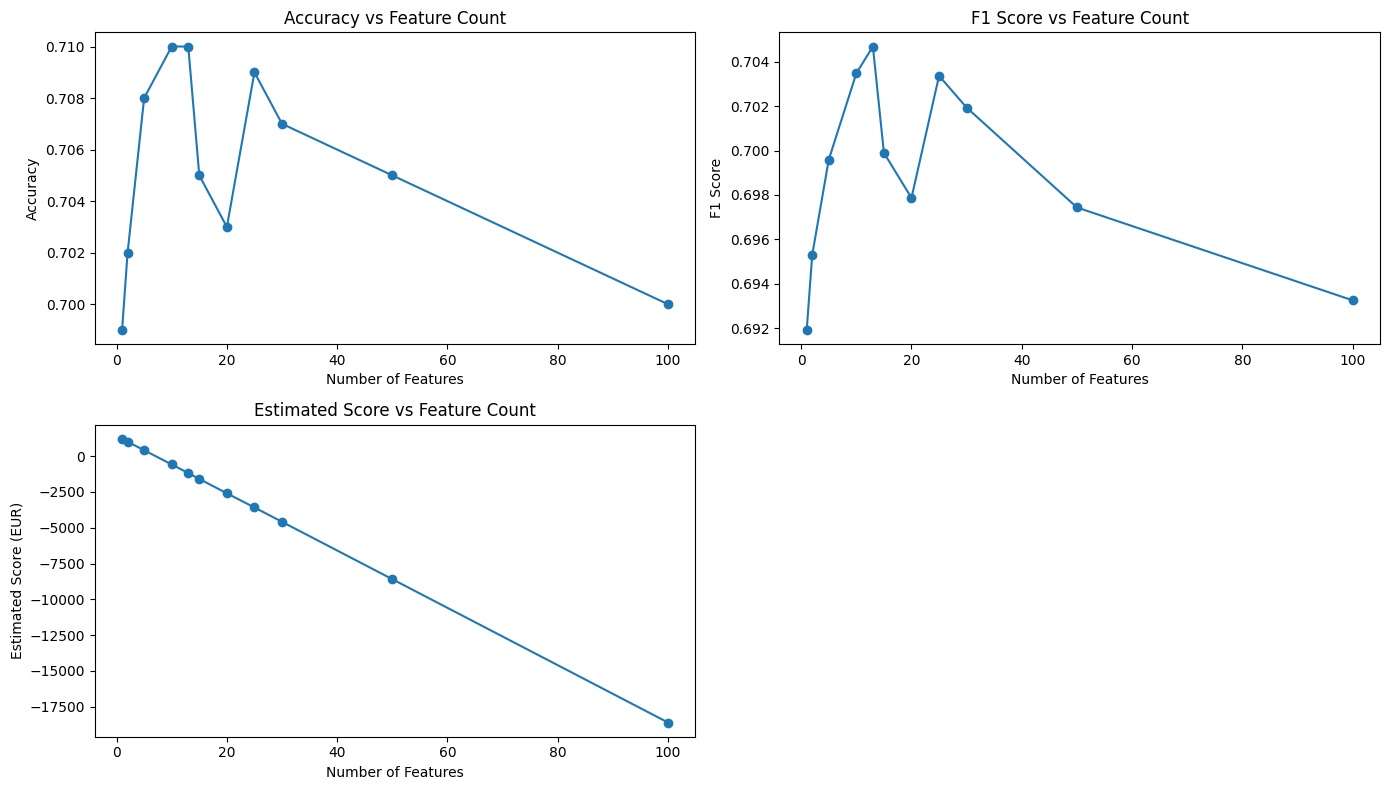

Optimal number of features (MDI): 1
Selected features (MDI): ['feature_2']


In [6]:
# Test different feature count thresholds based on MDI importance
thresholds = [1, 2, 5, 10, 13, 15, 20, 25, 30, 50, 100]
mdi_results = []

for n in thresholds:
    # Select top n features
    top_features = mdi_importances['feature'].head(n).values
    
    # Create datasets with selected features
    X_train_selected = X_train_split[top_features]
    X_val_selected = X_val[top_features]
    
    # Train model with selected features
    rf_selected = RandomForestClassifier(
    n_estimators=1000,
    max_depth=4,
    min_samples_split=4,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
        
    rf_selected.fit(X_train_selected, y_train_split)
    
    # Predict
    y_val_pred = rf_selected.predict(X_val_selected)
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)
    
    # Calculate expected score based on evaluation criteria
    # Let's assume 20% of validation set would be positive, similar to training distribution
    # This is just an estimate since we don't have the actual test labels
    estimated_correct = accuracy * len(y_val) * 0.2  # 20% of validation set with correct predictions
    reward = estimated_correct * 10
    cost = n * 200
    estimated_score = reward - cost
    
    mdi_results.append({
        'n_features': n,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'estimated_score': estimated_score
    })

# Convert results to DataFrame
mdi_results_df = pd.DataFrame(mdi_results)
print("MDI Feature Selection Results:")
print(mdi_results_df)

# Plot the results
plt.figure(figsize=(14, 8))
plt.subplot(2, 2, 1)
plt.plot(mdi_results_df['n_features'], mdi_results_df['accuracy'], marker='o')
plt.title('Accuracy vs Feature Count')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')

plt.subplot(2, 2, 2)
plt.plot(mdi_results_df['n_features'], mdi_results_df['f1'], marker='o')
plt.title('F1 Score vs Feature Count')
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')

plt.subplot(2, 2, 3)
plt.plot(mdi_results_df['n_features'], mdi_results_df['estimated_score'], marker='o')
plt.title('Estimated Score vs Feature Count')
plt.xlabel('Number of Features')
plt.ylabel('Estimated Score (EUR)')

plt.tight_layout()
plt.show()

# Find optimal number of features based on estimated score
optimal_n_features_mdi = mdi_results_df.loc[mdi_results_df['estimated_score'].idxmax(), 'n_features']
print(f"Optimal number of features (MDI): {optimal_n_features_mdi}")

# Get optimal features
optimal_features_mdi = mdi_importances['feature'].head(int(optimal_n_features_mdi)).values
print(f"Selected features (MDI): {optimal_features_mdi.tolist()}")

## 4. Feature Selection using Permutation Importance


Top 20 features by Permutation Importance:
        feature  importance
0     feature_2      0.0146
1   feature_414      0.0046
2     feature_8      0.0041
3     feature_6      0.0031
4     feature_5      0.0028
5   feature_425      0.0013
6    feature_97      0.0012
7   feature_303      0.0010
8   feature_222      0.0009
9    feature_38      0.0008
10  feature_140      0.0004
11  feature_367      0.0003
12   feature_86      0.0002
13  feature_115      0.0002
14   feature_43      0.0002
15  feature_102      0.0001
16  feature_499      0.0001
17  feature_157      0.0001
18  feature_175      0.0001
19  feature_332      0.0001


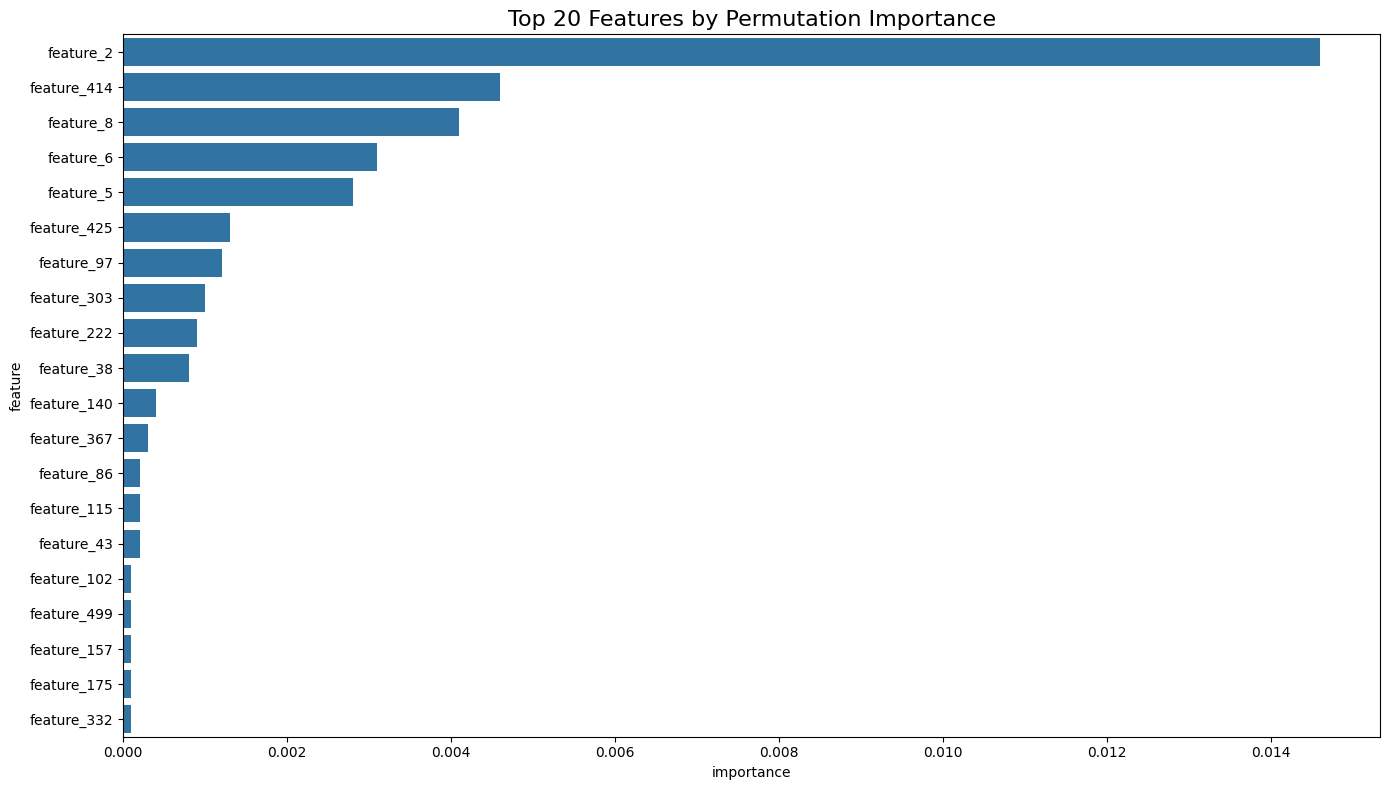

In [7]:
# Calculate permutation importance on validation set
perm_importance = permutation_importance(
    rf_model, X_val, y_val, n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1
)

# Store results in DataFrame
perm_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': perm_importance.importances_mean
})

# Sort features by importance
perm_importances = perm_importances.sort_values('importance', ascending=False).reset_index(drop=True)
print("\nTop 20 features by Permutation Importance:")
print(perm_importances.head(20))

# Visualize permutation feature importances
plt.figure(figsize=(14, 8))
sns.barplot(x='importance', y='feature', data=perm_importances.head(20))
plt.title('Top 20 Features by Permutation Importance', fontsize=16)
plt.tight_layout()
plt.show()

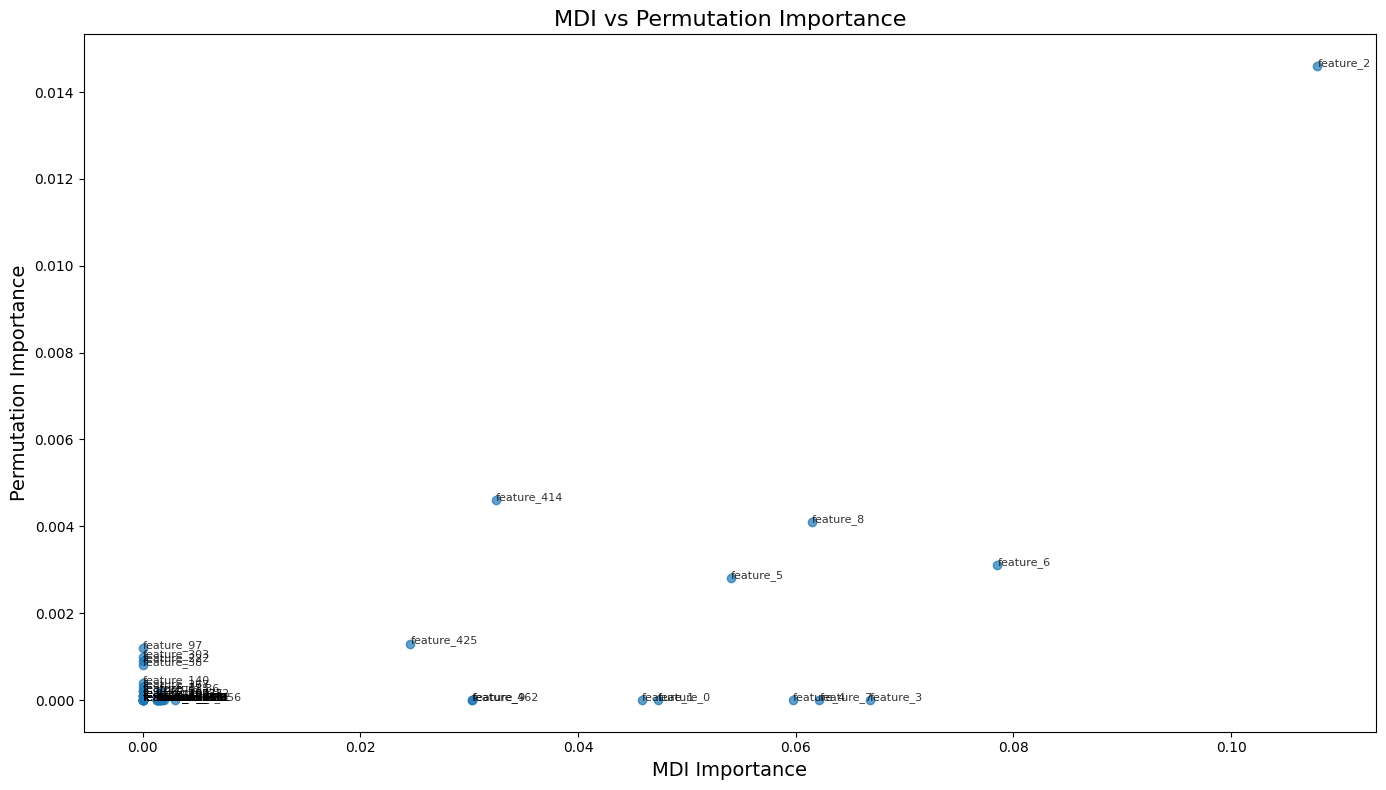

Permutation Feature Selection Results:
   n_features  accuracy  precision    recall        f1  estimated_score
0           1     0.550   0.539877  0.539877  0.539877            900.0
1           2     0.648   0.635108  0.658487  0.646586            896.0
2           5     0.700   0.689379  0.703476  0.696356            400.0
3          10     0.700   0.690909  0.699387  0.695122           -600.0
4          15     0.720   0.716356  0.707566  0.711934          -1560.0
5          20     0.707   0.701646  0.697342  0.699487          -2586.0
6          25     0.711   0.709205  0.693252  0.701138          -3578.0
7          30     0.714   0.709278  0.703476  0.706366          -4572.0
8          50     0.704   0.695740  0.701431  0.698574          -8592.0
9         100     0.706   0.702703  0.691207  0.696907         -18588.0
Optimal number of features (Permutation): 1
Selected features (Permutation): ['feature_2']


In [8]:
# Compare MDI and permutation importance
comparison = pd.merge(
    mdi_importances.head(30).rename(columns={'importance': 'mdi_importance'}),
    perm_importances.head(30).rename(columns={'importance': 'perm_importance'}),
    on='feature',
    how='outer'
).fillna(0)

plt.figure(figsize=(14, 8))
plt.scatter(comparison['mdi_importance'], comparison['perm_importance'], alpha=0.7)
plt.xlabel('MDI Importance', fontsize=14)
plt.ylabel('Permutation Importance', fontsize=14)
plt.title('MDI vs Permutation Importance', fontsize=16)

# Add feature names as labels
for i, txt in enumerate(comparison['feature']):
    plt.annotate(txt, (comparison['mdi_importance'].iloc[i], comparison['perm_importance'].iloc[i]), 
                 fontsize=8, alpha=0.8)

plt.tight_layout()
plt.show()

# Test different feature count thresholds based on permutation importance
thresholds = [1, 2, 5, 10, 15, 20, 25, 30, 50, 100]
perm_results = []

for n in thresholds:
    # Select top n features
    top_features = perm_importances['feature'].head(n).values
    
    # Create datasets with selected features
    X_train_selected = X_train_split[top_features]
    X_val_selected = X_val[top_features]
    
    # Train model with selected features
    rf_selected = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
    rf_selected.fit(X_train_selected, y_train_split)
    
    # Predict
    y_val_pred = rf_selected.predict(X_val_selected)
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)
    
    # Calculate expected score based on evaluation criteria
    estimated_correct = accuracy * len(y_val) * 0.2  # assume 20% positive
    reward = estimated_correct * 10
    cost = n * 200
    estimated_score = reward - cost
    
    perm_results.append({
        'n_features': n,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'estimated_score': estimated_score
    })

# Convert results to DataFrame
perm_results_df = pd.DataFrame(perm_results)
print("Permutation Feature Selection Results:")
print(perm_results_df)

# Find optimal number of features based on estimated score
optimal_n_features_perm = perm_results_df.loc[perm_results_df['estimated_score'].idxmax(), 'n_features']
print(f"Optimal number of features (Permutation): {optimal_n_features_perm}")

# Get optimal features
optimal_features_perm = perm_importances['feature'].head(int(optimal_n_features_perm)).values
print(f"Selected features (Permutation): {optimal_features_perm.tolist()}")

## 5. Feature Selection using Boruta Algorithm

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	481
Iteration: 	9 / 100
Confirmed: 	13
Tentative: 	6
Rejected: 	481
Iteration: 	10 / 100
Confirmed: 	13
Tentative: 	6
Rejected: 	481
Iteration: 	11 / 100
Confirmed: 	13
Tentative: 	6
Rejected: 	481
Iteration: 	12 / 100
Confirmed: 	13
Tentative: 	6
Rejected: 	481
Iteration: 	13 / 100
Confirmed: 	13
Tentative: 	6
Rejected: 	481
Iteration: 	14 / 100
Confirmed: 	13
Tentative: 	6
Rejected: 	481
Iteration: 	15 / 100
Confirmed: 	13
Tentative: 	6
Rejected: 	481
Iteration: 	16 / 100
Confirmed: 	13
Tenta

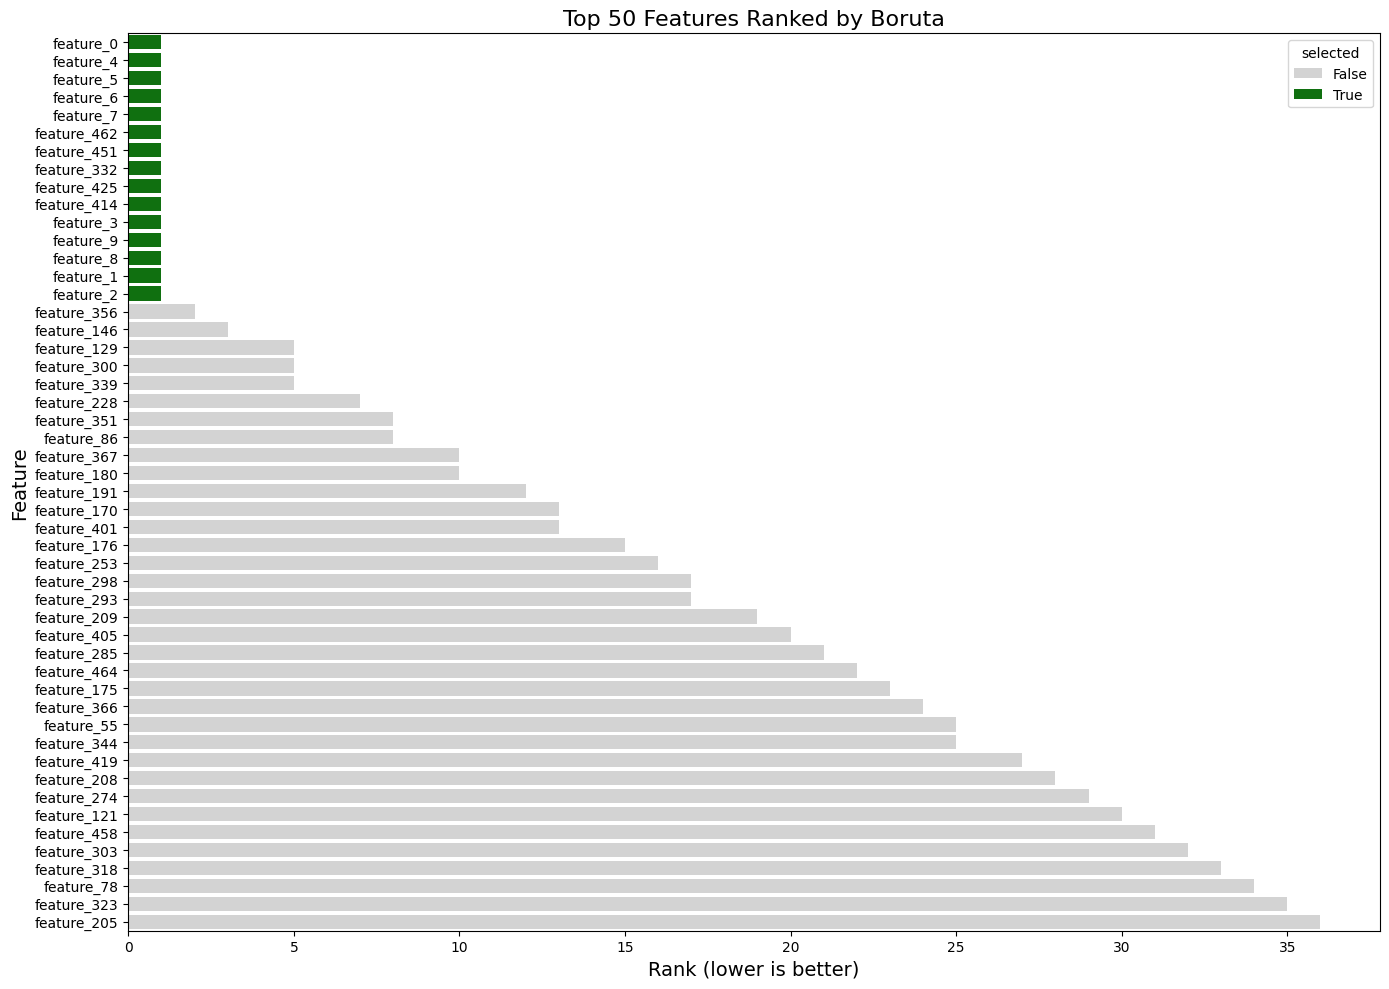

In [9]:
# Define the Boruta feature selector
rf_boruta = RandomForestClassifier(
    n_estimators=1000,
    max_depth=4,
    min_samples_split=4,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
boruta_selector = BorutaPy(
    rf_boruta, 
    n_estimators='auto',
    verbose=2,
    random_state=RANDOM_STATE
)

# Fit Boruta to the data
# Note: Boruta needs numpy arrays, not pandas DataFrames
boruta_selector.fit(X_train_split.values, y_train_split.values)

# Get the selected features
selected_features_mask = boruta_selector.support_
tentative_features_mask = boruta_selector.support_weak_

# Create a summary of the selection
feature_ranks = pd.DataFrame({
    'feature': X_train.columns,
    'rank': boruta_selector.ranking_,
    'selected': selected_features_mask,
    'tentative': tentative_features_mask
})

# Sort features by rank
feature_ranks = feature_ranks.sort_values('rank').reset_index(drop=True)
print("Boruta Feature Selection Results:")
print(feature_ranks.head(30))

# Print the number of selected and tentative features
print(f"\nSelected features: {selected_features_mask.sum()}")
print(f"Tentative features: {tentative_features_mask.sum()}")

# Get the list of selected features
selected_features_boruta = X_train.columns[selected_features_mask].tolist()
print(f"\nSelected features (Boruta): {selected_features_boruta}")

# Get the list of tentative features
tentative_features_boruta = X_train.columns[tentative_features_mask].tolist()
print(f"\nTentative features (Boruta): {tentative_features_boruta}")

# Visualize Boruta feature importances
plt.figure(figsize=(14, 10))
sns.barplot(x='rank', y='feature', data=feature_ranks.head(50), 
            hue='selected', palette=['lightgray', 'green'], dodge=False)
plt.title('Top 50 Features Ranked by Boruta', fontsize=16)
plt.xlabel('Rank (lower is better)', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()

In [10]:
# Evaluate Boruta selected features
X_train_boruta = X_train_split[selected_features_boruta]
X_val_boruta = X_val[selected_features_boruta]

rf_boruta_eval = RandomForestClassifier(
    n_estimators=1000,
    max_depth=4,
    min_samples_split=4,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_boruta_eval.fit(X_train_boruta, y_train_split)

# Predict
y_val_pred_boruta = rf_boruta_eval.predict(X_val_boruta)

# Calculate metrics
accuracy_boruta = accuracy_score(y_val, y_val_pred_boruta)
precision_boruta = precision_score(y_val, y_val_pred_boruta)
recall_boruta = recall_score(y_val, y_val_pred_boruta)
f1_boruta = f1_score(y_val, y_val_pred_boruta)

print("Boruta Selected Features Performance:")
print(f"Number of features: {len(selected_features_boruta)}")
print(f"Accuracy: {accuracy_boruta:.4f}")
print(f"Precision: {precision_boruta:.4f}")
print(f"Recall: {recall_boruta:.4f}")
print(f"F1 Score: {f1_boruta:.4f}")

# Calculate expected score
estimated_correct_boruta = accuracy_boruta * len(y_val) * 0.2  # assume 20% positive
reward_boruta = estimated_correct_boruta * 10
cost_boruta = len(selected_features_boruta) * 200
estimated_score_boruta = reward_boruta - cost_boruta
print(f"Estimated score (EUR): {estimated_score_boruta:.2f}")

# Try including tentative features
all_features_boruta = selected_features_boruta + tentative_features_boruta
X_train_all_boruta = X_train_split[all_features_boruta]
X_val_all_boruta = X_val[all_features_boruta]

rf_all_boruta_eval = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
rf_all_boruta_eval.fit(X_train_all_boruta, y_train_split)

# Predict
y_val_pred_all_boruta = rf_all_boruta_eval.predict(X_val_all_boruta)

# Calculate metrics
accuracy_all_boruta = accuracy_score(y_val, y_val_pred_all_boruta)
precision_all_boruta = precision_score(y_val, y_val_pred_all_boruta)
recall_all_boruta = recall_score(y_val, y_val_pred_all_boruta)
f1_all_boruta = f1_score(y_val, y_val_pred_all_boruta)

print("\nBoruta Selected + Tentative Features Performance:")
print(f"Number of features: {len(all_features_boruta)}")
print(f"Accuracy: {accuracy_all_boruta:.4f}")
print(f"Precision: {precision_all_boruta:.4f}")
print(f"Recall: {recall_all_boruta:.4f}")
print(f"F1 Score: {f1_all_boruta:.4f}")

# Calculate expected score
estimated_correct_all_boruta = accuracy_all_boruta * len(y_val) * 0.2  # assume 20% positive
reward_all_boruta = estimated_correct_all_boruta * 10
cost_all_boruta = len(all_features_boruta) * 200
estimated_score_all_boruta = reward_all_boruta - cost_all_boruta
print(f"Estimated score (EUR): {estimated_score_all_boruta:.2f}")

Boruta Selected Features Performance:
Number of features: 15
Accuracy: 0.7050
Precision: 0.6972
Recall: 0.7014
F1 Score: 0.6993
Estimated score (EUR): -1590.00

Boruta Selected + Tentative Features Performance:
Number of features: 16
Accuracy: 0.6970
Precision: 0.6883
Recall: 0.6953
F1 Score: 0.6918
Estimated score (EUR): -1806.00


## 6. Compare All Feature Selection Methods and Make Final Predictions

Comparison of Feature Selection Methods:
             Method  Number of Features  Accuracy  F1 Score  \
0               MDI                   1     0.699  0.691914   
1       Permutation                   1     0.550  0.539877   
2            Boruta                  15     0.705  0.699286   
3  Boruta+Tentative                  16     0.697  0.691760   

   Estimated Score (EUR)  
0                 1198.0  
1                  900.0  
2                -1590.0  
3                -1806.0  

Best Method: MDI
Number of Features: 1
Estimated Score: €1198.00
Selected features: ['feature_2']


,Method,Features Count,Train Accuracy,Val Accuracy,Train F1,Val F1,Feature Cost (EUR),Estimated Score (EUR)
0,MDI,1,0.7167,0.6990,0.7091,0.6919,€200,€1198.00
1,Permutation,1,0.9995,0.5500,0.9995,0.5399,€200,€900.00
2,Boruta,15,1.0000,0.7050,1.0000,0.6993,€3000,€-1590.00
3,Boruta+Tentative,16,1.0000,0.6970,1.0000,0.6918,€3200,€-1806.00


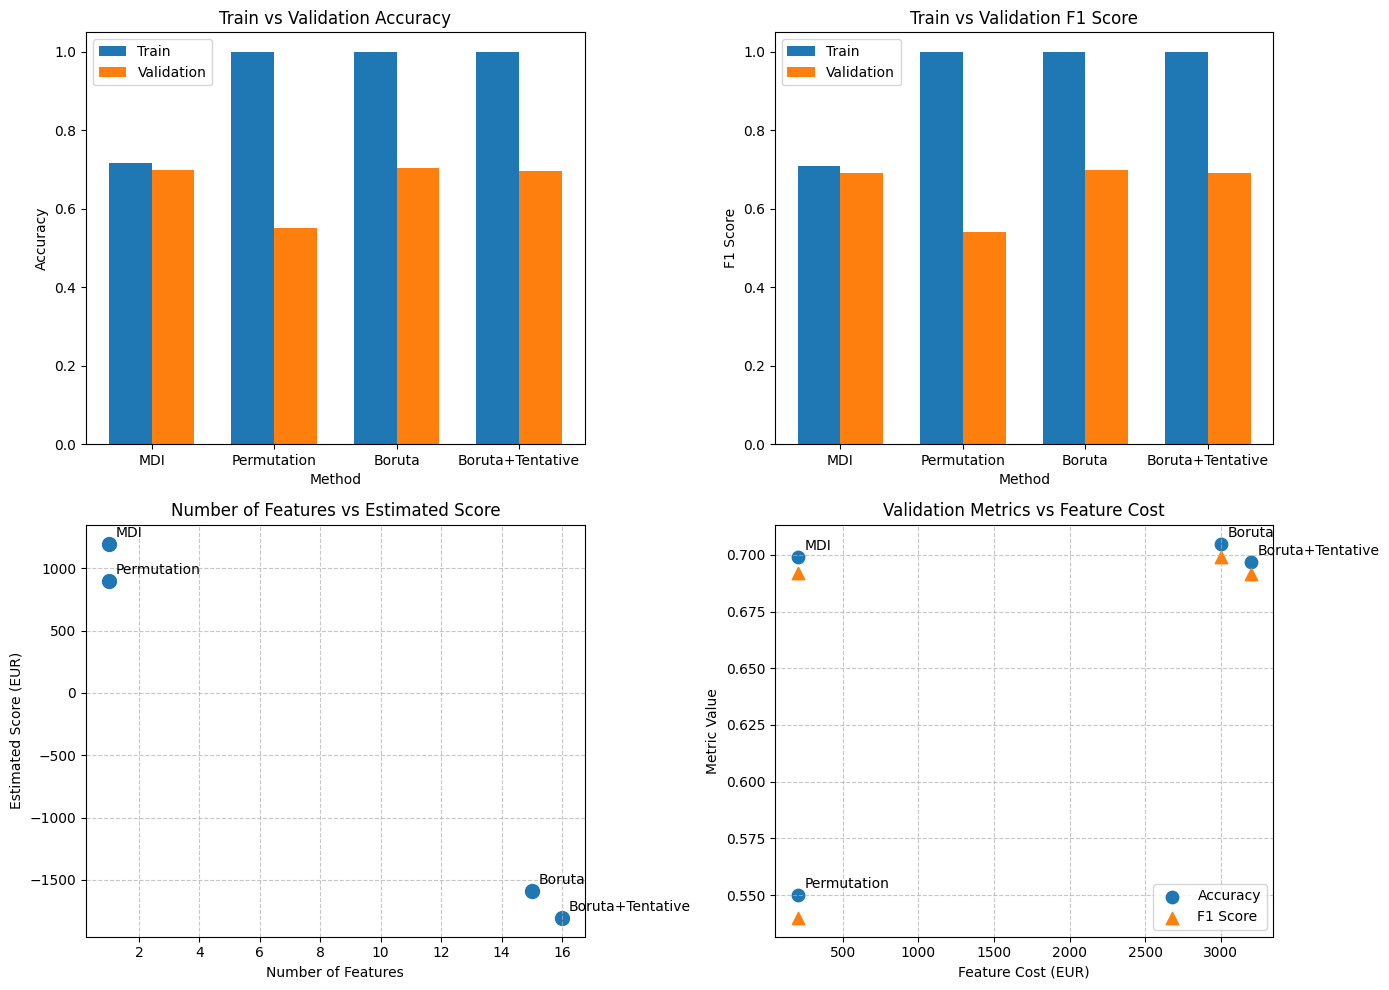

In [11]:
# Create a summary of all methods
method_comparison = pd.DataFrame({
    'Method': ['MDI', 'Permutation', 'Boruta', 'Boruta+Tentative'],
    'Number of Features': [
        optimal_n_features_mdi, 
        optimal_n_features_perm, 
        len(selected_features_boruta),
        len(all_features_boruta)
    ],
    'Accuracy': [
        mdi_results_df.loc[mdi_results_df['n_features'] == optimal_n_features_mdi, 'accuracy'].values[0],
        perm_results_df.loc[perm_results_df['n_features'] == optimal_n_features_perm, 'accuracy'].values[0],
        accuracy_boruta,
        accuracy_all_boruta
    ],
    'F1 Score': [
        mdi_results_df.loc[mdi_results_df['n_features'] == optimal_n_features_mdi, 'f1'].values[0],
        perm_results_df.loc[perm_results_df['n_features'] == optimal_n_features_perm, 'f1'].values[0],
        f1_boruta,
        f1_all_boruta
    ],
    'Estimated Score (EUR)': [
        mdi_results_df.loc[mdi_results_df['n_features'] == optimal_n_features_mdi, 'estimated_score'].values[0],
        perm_results_df.loc[perm_results_df['n_features'] == optimal_n_features_perm, 'estimated_score'].values[0],
        estimated_score_boruta,
        estimated_score_all_boruta
    ]
})

print("Comparison of Feature Selection Methods:")
print(method_comparison)

# Based on the comparison, select the best method
best_method_idx = method_comparison['Estimated Score (EUR)'].idxmax()
best_method = method_comparison.loc[best_method_idx]
print(f"\nBest Method: {best_method['Method']}")
print(f"Number of Features: {best_method['Number of Features']}")
print(f"Estimated Score: €{best_method['Estimated Score (EUR)']:.2f}")

# Get the features for the best method
if best_method['Method'] == 'MDI':
    best_features = mdi_importances['feature'].head(int(optimal_n_features_mdi)).values
elif best_method['Method'] == 'Permutation':
    best_features = perm_importances['feature'].head(int(optimal_n_features_perm)).values
elif best_method['Method'] == 'Boruta':
    best_features = selected_features_boruta
else:  # 'Boruta+Tentative'
    best_features = all_features_boruta

print(f"Selected features: {best_features}")

# Create a prettier DataFrame with both training and validation metrics
# First, compute train metrics for each method

# For MDI
top_features_mdi = mdi_importances['feature'].head(int(optimal_n_features_mdi)).values
X_train_mdi = X_train_split[top_features_mdi]
rf_mdi = RandomForestClassifier(
    n_estimators=1000,
    max_depth=4,
    min_samples_split=4,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_mdi.fit(X_train_mdi, y_train_split)
y_train_pred_mdi = rf_mdi.predict(X_train_mdi)
train_accuracy_mdi = accuracy_score(y_train_split, y_train_pred_mdi)
train_f1_mdi = f1_score(y_train_split, y_train_pred_mdi)

# For Permutation
top_features_perm = perm_importances['feature'].head(int(optimal_n_features_perm)).values
X_train_perm = X_train_split[top_features_perm]
rf_perm = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
rf_perm.fit(X_train_perm, y_train_split)
y_train_pred_perm = rf_perm.predict(X_train_perm)
train_accuracy_perm = accuracy_score(y_train_split, y_train_pred_perm)
train_f1_perm = f1_score(y_train_split, y_train_pred_perm)

# For Boruta
X_train_boruta_train = X_train_split[selected_features_boruta]
rf_boruta_train = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
rf_boruta_train.fit(X_train_boruta_train, y_train_split)
y_train_pred_boruta = rf_boruta_train.predict(X_train_boruta_train)
train_accuracy_boruta = accuracy_score(y_train_split, y_train_pred_boruta)
train_f1_boruta = f1_score(y_train_split, y_train_pred_boruta)

# For Boruta + Tentative
X_train_boruta_all_train = X_train_split[all_features_boruta]
rf_boruta_all_train = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
rf_boruta_all_train.fit(X_train_boruta_all_train, y_train_split)
y_train_pred_boruta_all = rf_boruta_all_train.predict(X_train_boruta_all_train)
train_accuracy_boruta_all = accuracy_score(y_train_split, y_train_pred_boruta_all)
train_f1_boruta_all = f1_score(y_train_split, y_train_pred_boruta_all)

# Create comprehensive comparison DataFrame
comprehensive_comparison = pd.DataFrame({
    'Method': ['MDI', 'Permutation', 'Boruta', 'Boruta+Tentative'],
    'Features Count': [
        optimal_n_features_mdi, 
        optimal_n_features_perm, 
        len(selected_features_boruta),
        len(all_features_boruta)
    ],
    'Train Accuracy': [
        train_accuracy_mdi,
        train_accuracy_perm,
        train_accuracy_boruta,
        train_accuracy_boruta_all
    ],
    'Val Accuracy': [
        mdi_results_df.loc[mdi_results_df['n_features'] == optimal_n_features_mdi, 'accuracy'].values[0],
        perm_results_df.loc[perm_results_df['n_features'] == optimal_n_features_perm, 'accuracy'].values[0],
        accuracy_boruta,
        accuracy_all_boruta
    ],
    'Train F1': [
        train_f1_mdi,
        train_f1_perm,
        train_f1_boruta,
        train_f1_boruta_all
    ],
    'Val F1': [
        mdi_results_df.loc[mdi_results_df['n_features'] == optimal_n_features_mdi, 'f1'].values[0],
        perm_results_df.loc[perm_results_df['n_features'] == optimal_n_features_perm, 'f1'].values[0],
        f1_boruta,
        f1_all_boruta
    ],
    'Feature Cost (EUR)': [
        optimal_n_features_mdi * 200, 
        optimal_n_features_perm * 200, 
        len(selected_features_boruta) * 200,
        len(all_features_boruta) * 200
    ],
    'Estimated Score (EUR)': [
        mdi_results_df.loc[mdi_results_df['n_features'] == optimal_n_features_mdi, 'estimated_score'].values[0],
        perm_results_df.loc[perm_results_df['n_features'] == optimal_n_features_perm, 'estimated_score'].values[0],
        estimated_score_boruta,
        estimated_score_all_boruta
    ]
})

# Display the comprehensive comparison as a styled DataFrame
from IPython.display import display
display(comprehensive_comparison.style.highlight_max(subset=['Val Accuracy', 'Val F1', 'Estimated Score (EUR)'], color='green')
       .highlight_min(subset=['Feature Cost (EUR)'], color='green')
       .format({'Train Accuracy': '{:.4f}', 'Val Accuracy': '{:.4f}', 
                'Train F1': '{:.4f}', 'Val F1': '{:.4f}',
                'Feature Cost (EUR)': '€{:.0f}', 'Estimated Score (EUR)': '€{:.2f}'}))

# Plot comparison metrics
plt.figure(figsize=(14, 10))

# Plot 1: Train vs Val Accuracy
plt.subplot(2, 2, 1)
bar_width = 0.35
index = np.arange(len(comprehensive_comparison['Method']))
plt.bar(index - bar_width/2, comprehensive_comparison['Train Accuracy'], bar_width, label='Train')
plt.bar(index + bar_width/2, comprehensive_comparison['Val Accuracy'], bar_width, label='Validation')
plt.xlabel('Method')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.xticks(index, comprehensive_comparison['Method'])
plt.legend()

# Plot 2: Train vs Val F1
plt.subplot(2, 2, 2)
plt.bar(index - bar_width/2, comprehensive_comparison['Train F1'], bar_width, label='Train')
plt.bar(index + bar_width/2, comprehensive_comparison['Val F1'], bar_width, label='Validation')
plt.xlabel('Method')
plt.ylabel('F1 Score')
plt.title('Train vs Validation F1 Score')
plt.xticks(index, comprehensive_comparison['Method'])
plt.legend()

# Plot 3: Features vs Estimated Score
plt.subplot(2, 2, 3)
plt.scatter(comprehensive_comparison['Features Count'], comprehensive_comparison['Estimated Score (EUR)'], s=100)
for i, method in enumerate(comprehensive_comparison['Method']):
    plt.annotate(method, 
                 (comprehensive_comparison['Features Count'].iloc[i], 
                  comprehensive_comparison['Estimated Score (EUR)'].iloc[i]),
                 xytext=(5, 5), textcoords='offset points')
plt.xlabel('Number of Features')
plt.ylabel('Estimated Score (EUR)')
plt.title('Number of Features vs Estimated Score')
plt.grid(True, linestyle='--', alpha=0.7)

# Plot 4: Validation Metrics vs Cost
plt.subplot(2, 2, 4)
plt.scatter(comprehensive_comparison['Feature Cost (EUR)'], comprehensive_comparison['Val Accuracy'], label='Accuracy', marker='o', s=80)
plt.scatter(comprehensive_comparison['Feature Cost (EUR)'], comprehensive_comparison['Val F1'], label='F1 Score', marker='^', s=80)
for i, method in enumerate(comprehensive_comparison['Method']):
    plt.annotate(method, 
                 (comprehensive_comparison['Feature Cost (EUR)'].iloc[i], 
                  comprehensive_comparison['Val Accuracy'].iloc[i]),
                 xytext=(5, 5), textcoords='offset points')
plt.xlabel('Feature Cost (EUR)')
plt.ylabel('Metric Value')
plt.title('Validation Metrics vs Feature Cost')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## 6.1 Detailed Analysis of Feature Selection Impact on Model Performance

Now that we've compared all feature selection methods, let's analyze the impact of feature selection on model performance, including both training and validation metrics, as well as the economic impact based on our cost-benefit structure.

,Method,Features Count,Train Accuracy,Val Accuracy,Accuracy Difference,Train F1,Val F1,F1 Difference,Estimated Score (EUR)
0,MDI,1,0.7167,0.6990,0.0178,0.7091,0.6919,0.0172,€1198.00
1,Permutation,1,0.9995,0.5500,0.4495,0.9995,0.5399,0.4596,€900.00
2,Boruta,15,1.0000,0.7050,0.2950,1.0000,0.6993,0.3007,€-1590.00
3,Boruta+Tentative,16,1.0000,0.6970,0.3030,1.0000,0.6918,0.3082,€-1806.00


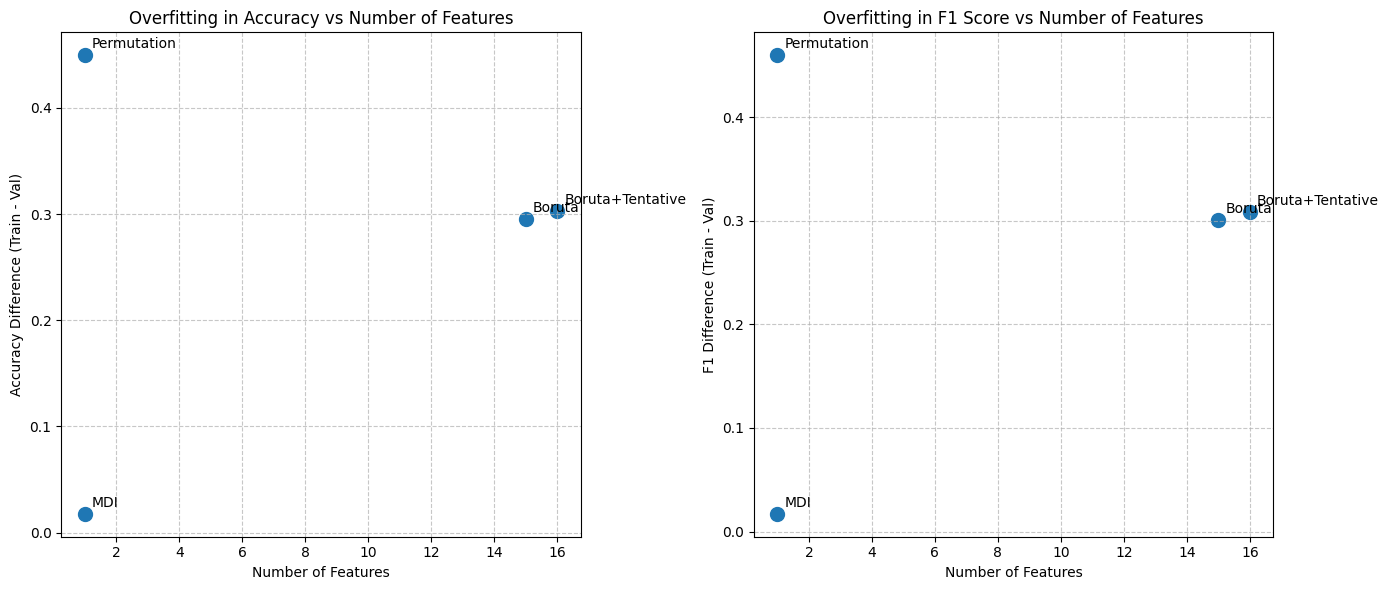

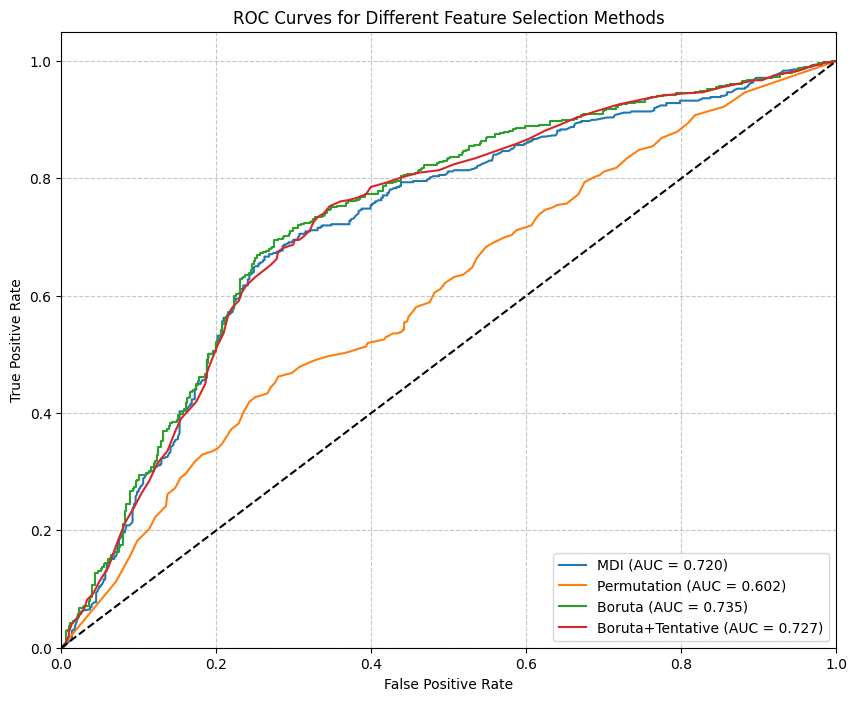

,Method,Features Count,Val Accuracy,Val F1,ROC AUC,Estimated Score (EUR)
0,MDI,1,0.6990,0.6919,0.7196,€1198.00
1,Permutation,1,0.5500,0.5399,0.6022,€900.00
2,Boruta,15,0.7050,0.6993,0.7352,€-1590.00
3,Boruta+Tentative,16,0.6970,0.6918,0.7274,€-1806.00


,Method 1,Method 2,Common Features,Method 1 Features,Method 2 Features,Overlap %
0,MDI,Permutation,1,1,1,100.0%
1,MDI,Boruta,1,1,15,100.0%
2,MDI,Boruta+Tentative,1,1,16,100.0%
3,Permutation,Boruta,1,1,15,100.0%
4,Permutation,Boruta+Tentative,1,1,16,100.0%
5,Boruta,Boruta+Tentative,15,15,16,100.0%


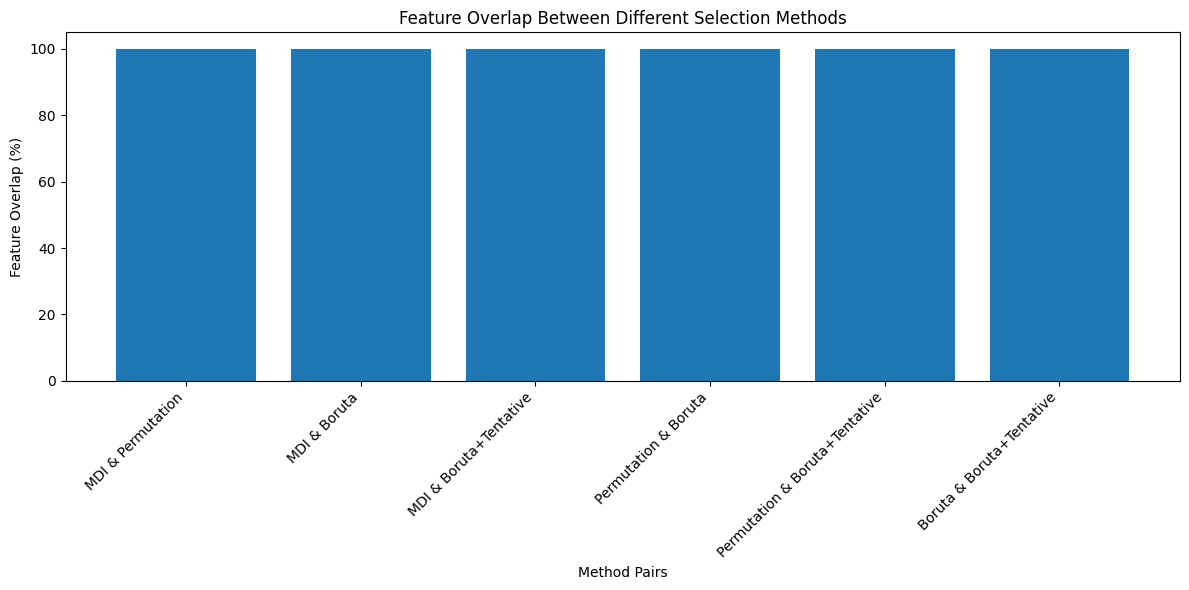

In [12]:
# Let's examine overfitting by calculating the difference between train and validation performance
comprehensive_comparison['Accuracy Difference'] = comprehensive_comparison['Train Accuracy'] - comprehensive_comparison['Val Accuracy']
comprehensive_comparison['F1 Difference'] = comprehensive_comparison['Train F1'] - comprehensive_comparison['Val F1']

# Display the updated DataFrame with overfitting metrics
display(comprehensive_comparison[['Method', 'Features Count', 'Train Accuracy', 'Val Accuracy', 
                                 'Accuracy Difference', 'Train F1', 'Val F1', 'F1 Difference', 
                                 'Estimated Score (EUR)']]
       .style.highlight_min(subset=['Accuracy Difference', 'F1 Difference'], color='lightgreen')
       .format({'Train Accuracy': '{:.4f}', 'Val Accuracy': '{:.4f}', 'Accuracy Difference': '{:.4f}',
                'Train F1': '{:.4f}', 'Val F1': '{:.4f}', 'F1 Difference': '{:.4f}',
                'Estimated Score (EUR)': '€{:.2f}'}))

# Visualize the relationship between number of features and overfitting
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(comprehensive_comparison['Features Count'], comprehensive_comparison['Accuracy Difference'], s=100)
for i, method in enumerate(comprehensive_comparison['Method']):
    plt.annotate(method, 
                 (comprehensive_comparison['Features Count'].iloc[i], 
                  comprehensive_comparison['Accuracy Difference'].iloc[i]),
                 xytext=(5, 5), textcoords='offset points')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy Difference (Train - Val)')
plt.title('Overfitting in Accuracy vs Number of Features')
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
plt.scatter(comprehensive_comparison['Features Count'], comprehensive_comparison['F1 Difference'], s=100)
for i, method in enumerate(comprehensive_comparison['Method']):
    plt.annotate(method, 
                 (comprehensive_comparison['Features Count'].iloc[i], 
                  comprehensive_comparison['F1 Difference'].iloc[i]),
                 xytext=(5, 5), textcoords='offset points')
plt.xlabel('Number of Features')
plt.ylabel('F1 Difference (Train - Val)')
plt.title('Overfitting in F1 Score vs Number of Features')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Calculate the ROC AUC for each method on validation set
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))

# MDI
y_val_pred_proba_mdi = rf_mdi.predict_proba(X_val[top_features_mdi])[:, 1]
fpr_mdi, tpr_mdi, _ = roc_curve(y_val, y_val_pred_proba_mdi)
roc_auc_mdi = auc(fpr_mdi, tpr_mdi)
plt.plot(fpr_mdi, tpr_mdi, label=f'MDI (AUC = {roc_auc_mdi:.3f})')

# Permutation
y_val_pred_proba_perm = rf_perm.predict_proba(X_val[top_features_perm])[:, 1]
fpr_perm, tpr_perm, _ = roc_curve(y_val, y_val_pred_proba_perm)
roc_auc_perm = auc(fpr_perm, tpr_perm)
plt.plot(fpr_perm, tpr_perm, label=f'Permutation (AUC = {roc_auc_perm:.3f})')

# Boruta
y_val_pred_proba_boruta = rf_boruta_eval.predict_proba(X_val_boruta)[:, 1]
fpr_boruta, tpr_boruta, _ = roc_curve(y_val, y_val_pred_proba_boruta)
roc_auc_boruta = auc(fpr_boruta, tpr_boruta)
plt.plot(fpr_boruta, tpr_boruta, label=f'Boruta (AUC = {roc_auc_boruta:.3f})')

# Boruta + Tentative
y_val_pred_proba_boruta_all = rf_all_boruta_eval.predict_proba(X_val_all_boruta)[:, 1]
fpr_boruta_all, tpr_boruta_all, _ = roc_curve(y_val, y_val_pred_proba_boruta_all)
roc_auc_boruta_all = auc(fpr_boruta_all, tpr_boruta_all)
plt.plot(fpr_boruta_all, tpr_boruta_all, label=f'Boruta+Tentative (AUC = {roc_auc_boruta_all:.3f})')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Feature Selection Methods')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Update the comprehensive comparison with AUC values
comprehensive_comparison['ROC AUC'] = [roc_auc_mdi, roc_auc_perm, roc_auc_boruta, roc_auc_boruta_all]
display(comprehensive_comparison[['Method', 'Features Count', 'Val Accuracy', 'Val F1', 'ROC AUC', 'Estimated Score (EUR)']]
       .style.highlight_max(subset=['Val Accuracy', 'Val F1', 'ROC AUC', 'Estimated Score (EUR)'], color='darkgreen')
       .format({'Val Accuracy': '{:.4f}', 'Val F1': '{:.4f}', 'ROC AUC': '{:.4f}',
                'Estimated Score (EUR)': '€{:.2f}'}))

# Let's also see the overlap in selected features between methods
mdi_features_set = set(top_features_mdi)
perm_features_set = set(top_features_perm)
boruta_features_set = set(selected_features_boruta)
boruta_all_features_set = set(all_features_boruta)

# Create a DataFrame to show feature overlap
overlap_df = pd.DataFrame({
    'Method 1': ['MDI', 'MDI', 'MDI', 'Permutation', 'Permutation', 'Boruta'],
    'Method 2': ['Permutation', 'Boruta', 'Boruta+Tentative', 'Boruta', 'Boruta+Tentative', 'Boruta+Tentative'],
    'Common Features': [
        len(mdi_features_set.intersection(perm_features_set)),
        len(mdi_features_set.intersection(boruta_features_set)),
        len(mdi_features_set.intersection(boruta_all_features_set)),
        len(perm_features_set.intersection(boruta_features_set)),
        len(perm_features_set.intersection(boruta_all_features_set)),
        len(boruta_features_set.intersection(boruta_all_features_set))
    ],
    'Method 1 Features': [
        len(mdi_features_set),
        len(mdi_features_set),
        len(mdi_features_set),
        len(perm_features_set),
        len(perm_features_set),
        len(boruta_features_set)
    ],
    'Method 2 Features': [
        len(perm_features_set),
        len(boruta_features_set),
        len(boruta_all_features_set),
        len(boruta_features_set),
        len(boruta_all_features_set),
        len(boruta_all_features_set)
    ]
})

# Calculate overlap percentages
overlap_df['Overlap %'] = overlap_df['Common Features'] / overlap_df[['Method 1 Features', 'Method 2 Features']].min(axis=1) * 100

display(overlap_df.style.format({'Overlap %': '{:.1f}%'}))

# Visualize feature overlap
plt.figure(figsize=(12, 6))
plt.bar(overlap_df['Method 1'] + ' & ' + overlap_df['Method 2'], overlap_df['Overlap %'])
plt.xlabel('Method Pairs')
plt.ylabel('Feature Overlap (%)')
plt.title('Feature Overlap Between Different Selection Methods')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Bonus: plot captured response

In [13]:
from src.captured_response import quant_stats, gain_curve_plotly

# Plot response curves for the best method
best_method_features = best_features
X_train_best = X_train_split[best_method_features]
rf_best = RandomForestClassifier(
    n_estimators=1000,
    max_depth=4,
    min_samples_split=4,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_best.fit(X_train_best, y_train_split)
y_val_pred = rf_best.predict(X_val[best_method_features])
y_val_pred_proba = rf_best.predict_proba(X_val[best_method_features])[:, 1]
df_quants = quant_stats(y_true=y_val, y_score=y_val_pred, q = 10)
gain_curve_plotly(df_quants)

c:\Users\Łukasz\OneDrive - Politechnika Warszawska\MINI_1D\Semestr 8\Advanced ML\Project_2\AML_Feature_Selection\src\captured_response.py:46: RuntimeWarning: invalid value encountered in scalar divide
  false_positive_share = false_positive/cust_capt


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': '% of base with the highest scores: %{x:.2%}<br>% of target captured: %{y:.2%}',
              'legendgroup': '',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'scatter',
              'x': {'bdata': ('AAAAAAAAAACamZmZmZm5P5qZmZmZmc' ... 'mZmek/zczMzMzM7D8AAAAAAADwPw=='),
                    'dtype': 'f8'},
              'xaxis': 'x',
              'y': {'bdata': ('AAAAAAAAAABxQYuGp8DAP4LI2WCvid' ... 'KcZuw/zGoUceik7T8AAAAAAADwPw=='),
                    'dtype': 'f8'},
              'yaxis': 'y'}],
    'layout': {'height': 700,
               'legend': {'tracegroupgap': 0},
               'shapes': [{'line': {'dash': 'dash'}, 'type': 'line', 'x0': 0, 'x1': np.float64(0.489), 'y0': 0, 'y1': 1},
                          {'line': {'dash': 'dash'}, 'type': 'line', 'x0': np.float64(0.489), 'x1': 1, 'y0': 1, 'y1': 1},
                          {'line': {'dash': 'dash'}, 'type': 'line', 'x0': 0, 'x1': 1, 'y0': 0, 'y1': 1}],
               'template': '...',
               'title': {'text': 'Gain curve (captured response)'},
               'width': 700,
               'xaxis': {'anchor': 'y',
                         'domain': [0.0, 1.0],
                         'range': [0, 1],
                         'tickformat': '.0%',
                         'title': {'text': '% of base with the highest scores'}},
               'yaxis': {'anchor': 'x',
                         'domain': [0.0, 1.0],
                         'range': [0, 1],
                         'tickformat': '.0%',
                         'title': {'text': '% of target captured'}}}
})